# Age-structured ICU demand sampler

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import minimize 
from datetime import timedelta
import datetime as dt
from IPython.display import Image
import requests

## Data

### Brazil

#### COVID-19 DATA

Data source: [Brasil.IO](https://brasil.io/dataset/covid19/caso). Observe the database changes every day.



In [10]:
#url = "https://brasil.io/dataset/covid19/caso/?format=csv"
#filename = 'data/brazil_' + url.split("/")[-3] + '.csv'
#with open(filename, "wb") as f:
#    r = requests.get(url)
#    f.write(r.content)

To keep the same analysis, we keep the data basis from May 17.

In [11]:
filename = 'data/brazil_covid19_05_17.csv'

df = pd.read_csv(filename)
df.head()

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-05-17,AL,Anadia,city,5,1,True,17545.0,2700201.0,28.49815,0.2000
1,2020-05-17,AL,Arapiraca,city,130,6,True,231747.0,2700300.0,56.09566,0.0462
2,2020-05-17,AL,Atalaia,city,29,1,True,47185.0,2700409.0,61.46021,0.0345
3,2020-05-17,AL,Barra de Santo Antônio,city,3,0,True,15932.0,2700508.0,18.83003,0.0000
4,2020-05-17,AL,Barra de São Miguel,city,9,0,True,8322.0,2700607.0,108.14708,0.0000


Select a particular state or city:

In [12]:
state_or_city = 'city'

In [13]:
name = ['Arujá',
 'Barueri',
 'Biritiba-Mirim',
 'Caieiras',
 'Cajamar',
 'Carapicuíba',
 'Cotia',
 'Diadema',
 'Embu',
 'Embu-Guaçu',
 'Ferraz de Vasconcelos',
 'Francisco Morato',
 'Franco da Rocha',
 'Guararema',
 'Guarulhos',
 'Itapecerica da Serra',
 'Itapevi',
 'Itaquaquecetuba',
 'Jandira',
 'Juquitiba',
 'Mairiporã',
 'Mauá',
 'Mogi das Cruzes',
 'Osasco',
 'Pirapora do Bom Jesus',
 'Poá',
 'Ribeirão Pires',
 'Rio Grande da Serra',
 'Salesópolis',
 'Santa Isabel',
 'Santana de Parnaíba',
 'Santo André',
 'Suzano',
 'São Bernardo do Campo',
 'São Caetano do Sul',
 'São Lourenço da Serra',
 'São Paulo',
 'Taboão da Serra',
 'Vargem Grande Paulista']

In [14]:
df = df[ df['place_type'] == state_or_city]
df = df[ df['city'].isin(name) ]

df_I = df.groupby('date')[['confirmed']].sum()
df_I.index = pd.to_datetime(df_I.index)
today = df_I.index[-1] + timedelta(days=1)

Last day of data used to run this notebook:

In [15]:
fit_until = df_I.index[-1].strftime('%m-%d')
fit_until

'05-17'

Eventually, data for some days are not avalible depending on the city or state. Thus, the must be a shift in the model to take these absent days into accont.

In [16]:
start = df_I.index[0]
end = df_I.index[-1]
time_I = pd.date_range(start, end, freq='D')

shift_NaN = np.abs( len(time_I) - len(df_I.index) )  

In [17]:
today = df_I.index[-1] + timedelta(days=1)

#### Population data combined with ICU adimission probability by age

Data source: [IBGE](https://www.ibge.gov.br/apps/populacao/projecao/).

In [18]:
# State of São Paulo
file = 'data/pop_age_str_IBGE_2020_' + 'SP' + '.csv'

# Other states
# file = 'data/pop_age_str_IBGE_2020_' + name + '.csv'

df_age = pd.read_csv(file)
df_age.loc[0, 'Age'] = '00-04'
df_age.loc[1, 'Age'] = '05-09'
df_age['AGE_prob'] = df_age['Total'] / df_age['Total'].sum()

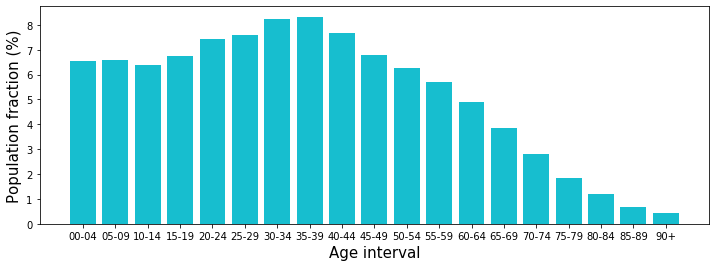

In [19]:
fig, ax = plt.subplots(figsize= (12, 4))
ax.bar(df_age['Age'], 100*df_age['AGE_prob'], color = 'C9')
ax.set_xlabel('Age interval', fontsize= 15)
ax.set_ylabel('Population fraction (%)', fontsize= 15)


plt.show()

Data source: [Severe Outcomes Among Patients with Coronavirus Disease 2019 (COVID-19) — United States, February 12–March 16, 2020](https://www.cdc.gov/mmwr/volumes/69/wr/mm6912e2.htm?s_cid=mm6912e2_w) by [CDC](https://www.cdc.gov/).

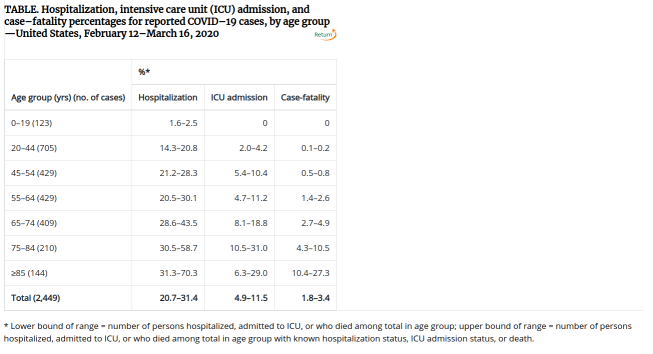

In [20]:
Image(filename= 'results/figures/____CDC_ICU_age.png') 

In [21]:
df_age_ICU = pd.DataFrame(columns=['Age', 'ICU_prob'])
df_age_ICU['Age'] = ['0-19', '20-44', '45-54', '55-64', '65-74', '75-84', '85+']
df_age_ICU['ICU_prob'] = [0, 4.2, 10.4, 11.2, 18.8, 31, 29]

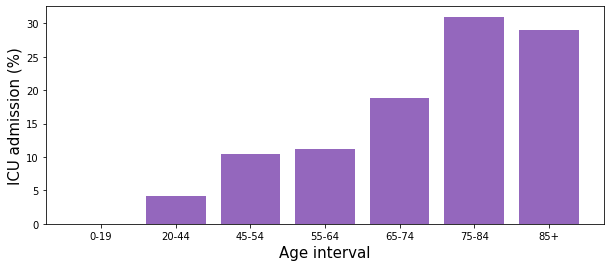

In [22]:
fig, ax = plt.subplots(figsize= (10, 4 ))
ax.bar(df_age_ICU['Age'], df_age_ICU['ICU_prob'], color = 'C4')
ax.set_xlabel('Age interval', fontsize= 15)
ax.set_ylabel('ICU admission (%)', fontsize= 15)

plt.show()

In [23]:
ICU_prob = [0., 0., 0., 0., 0.042, 
            0.042, 0.042, 0.042, 0.042, 0.104,
            0.104, 0.112, 0.112, 0.188, 0.188,
            0.31, 0.31, 0.29, 0.29]

df_age['ICU_prob'] = ICU_prob

### World

#### COVID-19 data

Data source: [Our World in Data](https://github.com/owid/covid-19-data/tree/master/public/data). Observe the database changes every day.

In [24]:
#url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
#filename = 'data/world_' + url.split("/")[-1]
#with open(filename, "wb") as f:
#    r = requests.get(url)
#    f.write(r.content)

To keep the same analysis, we keep the data basis from May 17.

In [25]:
filename = 'data/world_owid-covid-data_05_17.csv'

df_W = pd.read_csv(filename)
df_W = df_W[df_W.location != 'Hong Kong']
df_W = df_W[df_W['iso_code'].notna()]
df_W.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN


We focus on two scenarios defined on the other notebook (cite).

## Fit sigmoid over data

$$ \hat{n}(t) =  \frac{\hat{n}^{*}}{1 + e^{-\alpha(t - t_0)}}   \; \; \, $$


In [26]:
pop_SP = pd.read_excel('data/pop_state_SP_cities_IBGE.xls')
pop0 = pop_SP[ pop_SP['Município'].isin(name)]['População estimada [2019]'].sum()

In [27]:
country1 = 'Spain'
country2 = 'Switzerland'

frac1 = list(df_W[ df_W['location'] == country1]['total_cases_per_million'])[-1] / 10**6
frac2 = list(df_W[ df_W['location'] == country2]['total_cases_per_million'])[-1] / 10**6

n_star1 = frac1 * pop0
n_star2 = frac2 * pop0

### Linear regression over $\log(n^{*} / n(t)  - 1 )$

In [28]:
S = 1

X_ = np.arange(len(df_I))
X = X_.reshape(-1, 1)

# The model is fitted with a subnotification factor
y1 = np.log( n_star1 / np.array( S * df_I) - 1. )
y1 = y1.reshape(len(df_I)).reshape(-1, 1)

y2 = np.log( n_star2 / np.array( S * df_I) - 1. )
y2 = y2.reshape(len(df_I)).reshape(-1, 1)

In [29]:
t0 = 45

model1 = linear_model.LinearRegression()
model2 = linear_model.LinearRegression()

model1.fit(X[t0:], y1[t0:])
model2.fit(X[t0:], y2[t0:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

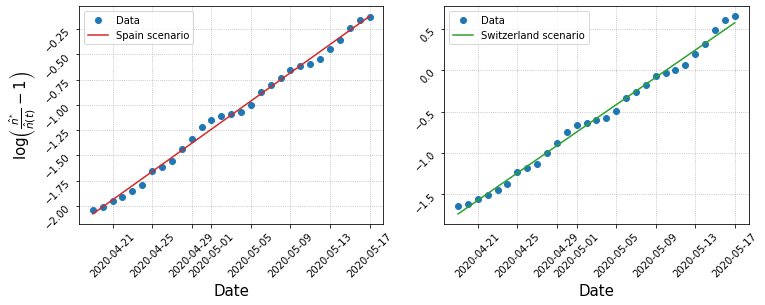

In [30]:
fig, axs = plt.subplots(1, 2, figsize= (12, 4))

axs[0].plot(df_I.index[t0:], -y1[t0:], 'o', color= 'C0', label= 'Data')
axs[0].plot(df_I.index[t0:], -model1.predict(X)[t0:], color= 'C3', label= country1 + ' scenario')
axs[0].grid(linestyle=':')
axs[0].set_xlabel('Date', fontsize= 15)
axs[0].set_ylabel('$ \\log \\left( \\frac{\\hat{n}^{*}}{\\hat{n}(t)} - 1 \\right) $', fontsize= 15)
axs[0].tick_params(labelrotation= 45)
axs[0].legend()

axs[1].plot(df_I.index[t0:], -y2[t0:], 'o', color= 'C0', label= 'Data')
axs[1].plot(df_I.index[t0:], -model2.predict(X)[t0:], color= 'C2', label= country2 + ' scenario')
axs[1].grid(linestyle=':')
axs[1].set_xlabel('Date', fontsize= 15)
axs[1].tick_params(labelrotation= 45)
axs[1].legend()
plt.show()

### Number of infected projections

In [31]:
def sigmoid(t, t0, alpha, n_star, shift_NaN= 0):
    return n_star / (1. + np.exp(-alpha*(t - t0 - shift_NaN)))

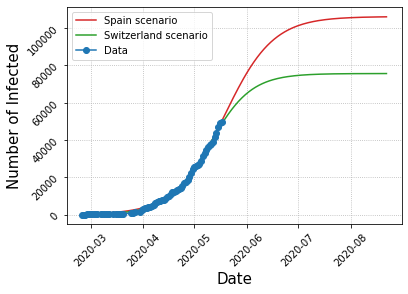

In [32]:
X__ = np.arange(0, 180)

start = df_I.index[0]
end = pd.to_datetime(start, format='%Y/%m/%d') + pd.DateOffset(days= len(X__) - 1)
time = pd.date_range(start, end, freq='D')

n1 = sigmoid(X__, 
             t0= -model1.intercept_[0] / model1.coef_[0][0], 
             alpha= -model1.coef_[0][0], 
             n_star= n_star1,
             shift_NaN= shift_NaN)

n2 = sigmoid(X__, 
             t0= -model2.intercept_[0] / model2.coef_[0][0], 
             alpha= -model2.coef_[0][0], 
             n_star= n_star2,
             shift_NaN= shift_NaN)


fig, ax = plt.subplots()

ax.plot(time, 
        sigmoid(X__, 
                t0= -model1.intercept_[0] / model1.coef_[0][0], 
                alpha= -model1.coef_[0][0], 
                n_star= n_star1,
                shift_NaN= shift_NaN), 
        color= 'C3', label= country1 + ' scenario')


ax.plot(time, 
        sigmoid(X__, 
                t0= -model2.intercept_[0] / model2.coef_[0][0], 
                alpha= -model2.coef_[0][0], 
                n_star= n_star2,
                shift_NaN= shift_NaN), 
        color= 'C2', label= country2 + ' scenario')

ax.plot(df_I.index, np.array(S * df_I['confirmed']), 'o-', color= 'C0', label= 'Data')

ax.grid(linestyle=':')
ax.set_xlabel('Date', fontsize= 15)
ax.set_ylabel('Number of Infected', fontsize= 15)
ax.tick_params(labelrotation= 45)
ax.legend()

plt.show()

## Sampling from age-structed population probability and ICU admission probability

Function to be used to performe both sampling over time.

In [33]:
def ICU_samp(df, n, n_samp_AGE_max= 1000, n_samp_AGE_min= 100, n_samp_ICU_max= 1000, n_samp_ICU_min= 100):

    df_samp = pd.DataFrame(columns= df['Age'])

    for j in range(n_samp_AGE_max):
    
        samp = np.random.choice(df['Age'], 
                                n, 
                                p= list(df['AGE_prob']) )

        unique, counts = np.unique(samp, return_counts= True)
    
        for l in range(len(unique)):
            df_samp.loc[j, unique[l]] = counts[l]


    df_samp = df_samp.fillna(0)
    df['n_mean'] = list(df_samp.mean(axis= 0))
    df['n_std']  = list(df_samp.std(axis =0))

    df = df.set_index('Age')

    for age in df.index:
    
        aux_ = []

        for j in range(n_samp_ICU_max):      
    
            samp = np.random.uniform(size= int(df.loc[age]['n_mean']))  
            samp_ICU = samp < df.loc[age]['ICU_prob']
            aux_.append(samp_ICU.sum())


        df.loc[age, 'n_mean_ICU']  = np.mean(aux_)
        df.loc[age, 'n_std_ICU']   = np.std(aux_)
        
    df['n_std_ICU'] = np.sqrt( df['n_std']**2 +  df['n_std_ICU']**2)
    
    return df

Running the function over both scenarios:

In [143]:
df1_ = []
df2_ = []

for j in range(len(n1)):
    
    df1 = ICU_samp(df= df_age.reset_index(), 
                   n= int(n1[j]), 
                   n_samp_AGE_max= 1000, n_samp_AGE_min= 100,
                   n_samp_ICU_max= 1000, n_samp_ICU_min= 100)

    df2 = ICU_samp(df= df_age.reset_index(), 
                   n = int(n2[j]), 
                   n_samp_AGE_max= 1000, n_samp_AGE_min= 100,
                   n_samp_ICU_max= 1000, n_samp_ICU_min= 100)
    
    df1_.append(df1)
    df2_.append(df2)

### Taking into account removal from ICU after `T_ICU` days

In [144]:
def correction(x, df_, T_ICU= 14):

    df_[x]['n_mean_ICU_cor'] = 0.
    df_[j]['n_std_ICU_cor'] = 0.
    
    if x <= T_ICU:
                   
        df_[x]['n_mean_ICU_cor'] = df_[x]['n_mean_ICU']
        df_[x]['n_std_ICU_cor']   = df_[x]['n_std_ICU']
             
    else:
        
        delta = df_[x]['n_mean_ICU'] - df_[x - T_ICU]['n_mean_ICU']
        
        df_[x]['n_mean_ICU_cor'] = np.heaviside(delta, 0) * delta
        df_[x]['n_std_ICU_cor']  = np.sqrt(df_[x]['n_std_ICU']**2 + df_[x - T_ICU]['n_std_ICU']**2)

In [145]:
T_ICU = 14

for x in range(len(df1_)):
    
    correction(x, df_= df1_, T_ICU= T_ICU)
    correction(x, df_= df2_, T_ICU= T_ICU)

## Collecting daily averages

Given a list `df_` of dataframes, the function `daily_av` collect averages of collumns values over a `timeseries_data` period. The return is a daaframe called `df_ICU`.

In [146]:
def daily_av(df_, timeseries_data, SUS= True, p_SUS= 0.6278, n_samp_max= 1000, n_samp_min= 100):

    n_mean_    = []
    n_std_     = []
    n_mean_ICU_ = []
    n_std_ICU_  = []

    for j in range(len(df_)):

        n_mean_.append(df_[j]['n_mean'].sum())
        n_std_.append( np.sqrt((df_[j]['n_std']**2).sum()) )
        
        n_mean_ICU_.append(df_[j]['n_mean_ICU_cor'].sum())
        n_std_ICU_.append( np.sqrt((df_[j]['n_std_ICU_cor']**2).sum()) )

    names = ['date', 'n_mean', 'n_std', 'n_mean_ICU', 'n_std_ICU']
    df_ICU = pd.DataFrame(columns= names)
    df_ICU['date'] = timeseries_data

    df_ICU['n_mean']     = n_mean_ 
    df_ICU['n_std']      = n_std_
    df_ICU['n_mean_ICU'] = n_mean_ICU_
    df_ICU['n_std_ICU']  = n_std_ICU_

    df_ICU = df_ICU.set_index(['date'])


    if SUS:

        for date in df_ICU.index:
            
            aux_ = []

            for j in range(n_samp_max):

                samp = np.random.uniform(size= int(df_ICU.loc[date]['n_mean_ICU']))  
                SUS_samp = samp <= p_SUS
                aux_.append(SUS_samp.sum())



            df_ICU.loc[date, 'n_mean_ICU_SUS'] = np.mean(aux_)
            df_ICU.loc[date, 'n_std_ICU_SUS']  = np.std(aux_)

        df_ICU['n_std_ICU_SUS'] = np.sqrt( df_ICU['n_std_ICU']**2 +  df_ICU['n_std_ICU_SUS']**2)

    return df_ICU

In [147]:
df1_ICU = daily_av(df1_, timeseries_data= time, SUS= True, p_SUS= 0.6278, n_samp_max= 1000, n_samp_min= 100)
df2_ICU = daily_av(df2_, timeseries_data= time, SUS= True, p_SUS= 0.6278, n_samp_max= 1000, n_samp_min= 100)

## Median between two scenarios

In [148]:
df_median = pd.DataFrame(columns= ['date', 'median', 'std', 'median_SUS', 'std_SUS'])

df_median['date'] = df1_ICU.index
df_median['median'] = np.median([df1_ICU['n_mean_ICU'], df2_ICU['n_mean_ICU']], axis=0)
df_median['std'] = np.median([df1_ICU['n_std_ICU'], df2_ICU['n_std_ICU']], axis=0)
df_median['median_SUS'] = np.median([df1_ICU['n_mean_ICU_SUS'], df2_ICU['n_mean_ICU_SUS']], axis=0)
df_median['std_SUS'] = np.median([df1_ICU['n_std_ICU_SUS'], df2_ICU['n_std_ICU_SUS']], axis=0)
df_median = df_median.set_index('date')

df_median.index = pd.to_datetime(df_median.index)

## Private ICU beds

In [149]:
df1_ICU['n_mean_ICU_PRIVATE'] = df1_ICU['n_mean_ICU'] - df1_ICU['n_mean_ICU_SUS'] 
df1_ICU['n_std_ICU_PRIVATE'] = np.sqrt(  df1_ICU['n_std_ICU']**2 + df1_ICU['n_std_ICU_SUS']  )

df2_ICU['n_mean_ICU_PRIVATE'] = df2_ICU['n_mean_ICU'] - df2_ICU['n_mean_ICU_SUS'] 
df2_ICU['n_std_ICU_PRIVATE'] = np.sqrt(  df2_ICU['n_std_ICU']**2 + df2_ICU['n_std_ICU_SUS']  )

df_median['median_PRIVATE'] = df_median['median'] - df_median['median_SUS'] 
df_median['std_PRIVATE'] = np.sqrt(  df_median['median']**2 + df_median['median_SUS']  )

## Saving the results. 

In [150]:
name = 'grande_SP'

file1 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + country1 + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'
file2 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + country2 + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'
file3 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + 'MEDIAN' + '_t0=' + str(t0) + '_fit_until_' + fit_until + '_' + country1 + '_' + country2 + '.pkl'


df1_ICU.to_pickle(file1) 
df2_ICU.to_pickle(file2) 
df_median.to_pickle(file3)